In [1]:
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install packages if needed
packages = ['bokeh', 'panel', 'numpy', 'pandas', 'matplotlib']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import threading
import queue
import math
import json
from collections import deque
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Bokeh imports
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import ColumnDataSource, HoverTool, DatetimeTickFormatter
from bokeh.layouts import column, row, gridplot
from bokeh.io import curdoc
from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
import panel as pn


In [4]:
# ===========================
# DATA PREPARATION
# ===========================

# Load the parking dataset
df = pd.read_csv('dataset.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Columns:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Data preprocessing
def prepare_data(df):
    """Prepare and clean the parking dataset"""
    # Handle timestamps
    df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                     format='%d-%m-%Y %H:%M:%S')
    
    # Sort by timestamp
    df = df.sort_values('Timestamp').reset_index(drop=True)
    
    # Map traffic conditions to numeric values
    traffic_map = {'low': 25, 'medium': 50, 'high': 75, 'very_high': 100}
    df['TrafficLevel'] = df['TrafficConditionNearby'].map(traffic_map).fillna(50)
    
    # Add parking space ID based on SystemCodeNumber
    unique_codes = df['SystemCodeNumber'].unique()
    code_to_id = {code: i+1 for i, code in enumerate(unique_codes)}
    df['ParkingSpaceID'] = df['SystemCodeNumber'].map(code_to_id)
    
    # Ensure all required columns exist
    required_columns = {
        'Occupancy': df['Occupancy'],
        'Capacity': df['Capacity'],
        'QueueLength': df['QueueLength'],
        'TrafficLevel': df['TrafficLevel'],
        'IsSpecialDay': df['IsSpecialDay'],
        'VehicleType': df['VehicleType'],
        'Latitude': df['Latitude'],
        'Longitude': df['Longitude'],
        'ParkingSpaceID': df['ParkingSpaceID']
    }
    
    return df

# Prepare the data
df = prepare_data(df)

# ===========================
# PRICING MODELS
# ===========================

class ParkingPricingEngine:
    def __init__(self, base_price=10, max_multiplier=2.0, min_multiplier=0.5):
        self.base_price = base_price
        self.max_multiplier = max_multiplier
        self.min_multiplier = min_multiplier
        self.price_history = {}
        
    def model_1_linear(self, occupancy, capacity, previous_price=None):
        """
        Model 1: Baseline Linear Model
        Simple linear relationship between occupancy and price
        """
        if previous_price is None:
            previous_price = self.base_price
            
        alpha = 0.5  # Sensitivity parameter
        occupancy_rate = occupancy / capacity if capacity > 0 else 0
        
        price_adjustment = alpha * occupancy_rate
        new_price = previous_price + price_adjustment
        
        # Ensure price bounds
        new_price = max(self.base_price * self.min_multiplier, 
                       min(self.base_price * self.max_multiplier, new_price))
        
        return new_price
    
    def model_2_demand_based(self, occupancy, capacity, queue_length, traffic_level, 
                           is_special_day, vehicle_type):
        """
        Model 2: Demand-Based Price Function
        Advanced model considering multiple demand factors
        """
        # Normalize inputs
        occupancy_rate = occupancy / capacity if capacity > 0 else 0
        normalized_queue = min(queue_length / 10, 1.0)  # Normalize to [0,1]
        normalized_traffic = min(traffic_level / 100, 1.0)  # Normalize to [0,1]
        
        # Vehicle type weights
        vehicle_weights = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}
        vehicle_weight = vehicle_weights.get(vehicle_type, 1.0)
        
        # Demand function parameters
        alpha = 0.4  # Occupancy weight
        beta = 0.3   # Queue weight
        gamma = 0.2  # Traffic penalty (negative effect)
        delta = 0.3  # Special day bonus
        epsilon = 0.1 # Vehicle type weight
        
        # Calculate demand score
        demand = (alpha * occupancy_rate + 
                 beta * normalized_queue - 
                 gamma * normalized_traffic + 
                 delta * is_special_day + 
                 epsilon * vehicle_weight)
        
        # Normalize demand to reasonable bounds
        demand = max(-1, min(1, demand))
        
        # Apply demand to price
        price_multiplier = 1 + 0.5 * demand  # Lambda = 0.5
        new_price = self.base_price * price_multiplier
        
        # Ensure price bounds
        new_price = max(self.base_price * self.min_multiplier, 
                       min(self.base_price * self.max_multiplier, new_price))
        
        return new_price
    
    def calculate_distance(self, lat1, lon1, lat2, lon2):
        """Calculate distance between two points using Haversine formula"""
        R = 6371  # Earth's radius in kilometers
        
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
        
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        
        return R * c
    
    def model_3_competitive(self, occupancy, capacity, queue_length, traffic_level,
                          is_special_day, vehicle_type, lat, lon, competitor_data):
        """
        Model 3: Competitive Pricing Model
        Considers nearby competitors and geographic proximity
        """
        # Start with demand-based price
        base_demand_price = self.model_2_demand_based(
            occupancy, capacity, queue_length, traffic_level, 
            is_special_day, vehicle_type)
        
        # Find nearby competitors (within 1km radius)
        nearby_competitors = []
        for competitor in competitor_data:
            distance = self.calculate_distance(lat, lon, 
                                             competitor['lat'], competitor['lon'])
            if distance <= 1.0:  # Within 1km
                nearby_competitors.append({
                    'price': competitor['price'],
                    'distance': distance,
                    'occupancy_rate': competitor['occupancy'] / competitor['capacity']
                })
        
        if not nearby_competitors:
            return base_demand_price
        
        # Calculate competitive adjustment
        avg_competitor_price = np.mean([c['price'] for c in nearby_competitors])
        min_competitor_price = min([c['price'] for c in nearby_competitors])
        
        # Current lot utilization
        current_utilization = occupancy / capacity if capacity > 0 else 0
        
        # Competitive pricing logic
        if current_utilization > 0.9:  # Nearly full
            if base_demand_price > avg_competitor_price:
                # Suggest rerouting or reduce price slightly
                competitive_price = min(base_demand_price, avg_competitor_price * 1.1)
            else:
                competitive_price = base_demand_price
        else:
            # Room available - can be competitive
            if avg_competitor_price > base_demand_price:
                # Can increase price while staying competitive
                competitive_price = min(base_demand_price * 1.2, avg_competitor_price * 0.95)
            else:
                competitive_price = base_demand_price
        
        # Ensure price bounds
        competitive_price = max(self.base_price * self.min_multiplier, 
                              min(self.base_price * self.max_multiplier, competitive_price))
        
        return competitive_price


Dataset Shape: (18368, 12)

Dataset Columns:
['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime']

First few rows:
   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy VehicleType  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61         car   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64         car   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80         car   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107         car   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150        bike   

  TrafficConditionNearby  QueueLength  IsSpecialDay LastUpdatedDate  \
0                    low            1             0      04-10-2016   
1                    low            1             0      04-10-2016   
2                    low            2             0

In [5]:
# ===========================
# REAL-TIME SIMULATION CLASS
# ===========================

class RealTimeSimulator:
    def __init__(self, data, pricing_engine, update_interval=2):
        self.data = data
        self.pricing_engine = pricing_engine
        self.update_interval = update_interval
        self.current_index = 0
        self.is_running = False
        self.data_queue = queue.Queue()
        self.processed_data = []
        
    def process_row(self, row):
        """Process a single row of data and calculate price"""
        price = self.pricing_engine.model_2_demand_based(
            row['Occupancy'], row['Capacity'], row['QueueLength'],
            row['TrafficLevel'], row['IsSpecialDay'], row['VehicleType']
        )
        
        processed_row = {
            'Timestamp': row['Timestamp'],
            'ParkingSpaceID': row['ParkingSpaceID'],
            'Occupancy': row['Occupancy'],
            'Capacity': row['Capacity'],
            'QueueLength': row['QueueLength'],
            'TrafficLevel': row['TrafficLevel'],
            'IsSpecialDay': row['IsSpecialDay'],
            'VehicleType': row['VehicleType'],
            'Price': round(price, 2),
            'OccupancyRate': row['Occupancy'] / row['Capacity'] if row['Capacity'] > 0 else 0
        }
        
        return processed_row
    
    def run_simulation(self):
        """Run the real-time simulation"""
        self.is_running = True
        
        while self.is_running and self.current_index < len(self.data):
            row = self.data.iloc[self.current_index]
            processed_row = self.process_row(row)
            
            self.data_queue.put(processed_row)
            self.processed_data.append(processed_row)
            
            self.current_index += 1
            time.sleep(self.update_interval)
        
        self.is_running = False
    
    def start(self):
        """Start the simulation in a separate thread"""
        self.simulation_thread = threading.Thread(target=self.run_simulation)
        self.simulation_thread.daemon = True
        self.simulation_thread.start()
    
    def stop(self):
        """Stop the simulation"""
        self.is_running = False
        if hasattr(self, 'simulation_thread'):
            self.simulation_thread.join()
    
    def get_latest_data(self, n=100):
        """Get the latest n data points"""
        return self.processed_data[-n:] if len(self.processed_data) >= n else self.processed_data


In [6]:
# ===========================
# VISUALIZATION FUNCTIONS
# ===========================

def create_bokeh_dashboard(simulator):
    """Create a Bokeh dashboard for real-time visualization"""
    
    # Create data source
    source = ColumnDataSource(data=dict(
        timestamp=[], price=[], occupancy_rate=[], 
        queue_length=[], parking_id=[], traffic_level=[]
    ))
    
    # Create plots
    price_plot = figure(
        title="Real-Time Dynamic Parking Prices",
        x_axis_type="datetime",
        height=400,
        width=800,
        tools="pan,wheel_zoom,box_zoom,reset,save"
    )
    
    price_plot.line('timestamp', 'price', source=source, line_width=2, color='navy', alpha=0.8)
    price_plot.circle('timestamp', 'price', source=source, size=6, color='red', alpha=0.7)
    
    occupancy_plot = figure(
        title="Parking Occupancy Rates",
        x_axis_type="datetime",
        height=400,
        width=800,
        tools="pan,wheel_zoom,box_zoom,reset,save"
    )
    
    occupancy_plot.line('timestamp', 'occupancy_rate', source=source, line_width=2, color='green', alpha=0.8)
    occupancy_plot.circle('timestamp', 'occupancy_rate', source=source, size=6, color='orange', alpha=0.7)
    
    demand_plot = figure(
        title="Parking Demand Indicators",
        x_axis_type="datetime",
        height=400,
        width=800,
        tools="pan,wheel_zoom,box_zoom,reset,save"
    )
    
    demand_plot.line('timestamp', 'queue_length', source=source, line_width=2, color='purple', alpha=0.8)
    demand_plot.circle('timestamp', 'queue_length', source=source, size=6, color='blue', alpha=0.7)
    
    # Add hover tools
    for plot in [price_plot, occupancy_plot, demand_plot]:
        hover = HoverTool(tooltips=[
            ("Time", "@timestamp{%F %T}"),
            ("Value", "@y{0.00}"),
            ("Parking ID", "@parking_id")
        ], formatters={'@timestamp': 'datetime'})
        plot.add_tools(hover)
    
    # Update function
    def update():
        latest_data = simulator.get_latest_data(50)
        if latest_data:
            timestamps = [pd.to_datetime(d['Timestamp']) for d in latest_data]
            prices = [d['Price'] for d in latest_data]
            occupancy_rates = [d['OccupancyRate'] for d in latest_data]
            queue_lengths = [d['QueueLength'] for d in latest_data]
            parking_ids = [d['ParkingSpaceID'] for d in latest_data]
            traffic_levels = [d['TrafficLevel'] for d in latest_data]
            
            source.data = dict(
                timestamp=timestamps,
                price=prices,
                occupancy_rate=occupancy_rates,
                queue_length=queue_lengths,
                parking_id=parking_ids,
                traffic_level=traffic_levels
            )
    
    # Add periodic callback
    curdoc().add_periodic_callback(update, 2000)  # Update every 2 seconds
    
    # Create layout
    layout = column(price_plot, occupancy_plot, demand_plot)
    
    return layout

In [7]:
# ===========================
# ANALYSIS AND INSIGHTS
# ===========================

def analyze_pricing_scenarios():
    """Analyze different pricing scenarios"""
    pricing_engine = ParkingPricingEngine()
    
    print("\n" + "="*50)
    print("DYNAMIC PARKING PRICING ANALYSIS")
    print("="*50)
    
    print(f"Base Price: ${pricing_engine.base_price}")
    print(f"Price Range: ${pricing_engine.base_price * pricing_engine.min_multiplier:.2f} - ${pricing_engine.base_price * pricing_engine.max_multiplier:.2f}")
    
    print("\nPRICING SCENARIOS:")
    print("-" * 30)
    
    test_scenarios = [
        {"name": "Low Demand", "occupancy": 10, "capacity": 50, "queue": 0, "traffic": 25, "special": 0, "vehicle": "car"},
        {"name": "Medium Demand", "occupancy": 30, "capacity": 50, "queue": 5, "traffic": 50, "special": 0, "vehicle": "car"},
        {"name": "High Demand", "occupancy": 45, "capacity": 50, "queue": 10, "traffic": 75, "special": 0, "vehicle": "car"},
        {"name": "Special Event", "occupancy": 40, "capacity": 50, "queue": 15, "traffic": 100, "special": 1, "vehicle": "car"},
        {"name": "Truck Peak", "occupancy": 35, "capacity": 50, "queue": 8, "traffic": 60, "special": 0, "vehicle": "truck"},
        {"name": "Bike Light", "occupancy": 20, "capacity": 50, "queue": 2, "traffic": 30, "special": 0, "vehicle": "bike"}
    ]
    
    for scenario in test_scenarios:
        # Test all three models
        linear_price = pricing_engine.model_1_linear(scenario["occupancy"], scenario["capacity"])
        demand_price = pricing_engine.model_2_demand_based(
            scenario["occupancy"], scenario["capacity"], scenario["queue"],
            scenario["traffic"], scenario["special"], scenario["vehicle"]
        )
        
        print(f"{scenario['name']:<15}: Linear=${linear_price:.2f}, Demand-Based=${demand_price:.2f}")
    
    return pricing_engine


In [8]:
# ===========================
# STATIC ANALYSIS AND VISUALIZATION
# ===========================

def create_static_analysis():
    """Create static analysis plots"""
    pricing_engine = ParkingPricingEngine()
    
    # Sample data for analysis
    sample_data = df.sample(1000).copy()
    
    # Calculate prices for sample data
    sample_data['LinearPrice'] = sample_data.apply(
        lambda row: pricing_engine.model_1_linear(row['Occupancy'], row['Capacity']), axis=1
    )
    
    sample_data['DemandPrice'] = sample_data.apply(
        lambda row: pricing_engine.model_2_demand_based(
            row['Occupancy'], row['Capacity'], row['QueueLength'],
            row['TrafficLevel'], row['IsSpecialDay'], row['VehicleType']
        ), axis=1
    )
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Price vs Occupancy Rate
    occupancy_rate = sample_data['Occupancy'] / sample_data['Capacity']
    axes[0, 0].scatter(occupancy_rate, sample_data['DemandPrice'], alpha=0.6, color='blue')
    axes[0, 0].set_xlabel('Occupancy Rate')
    axes[0, 0].set_ylabel('Price ($)')
    axes[0, 0].set_title('Price vs Occupancy Rate')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Price vs Queue Length
    axes[0, 1].scatter(sample_data['QueueLength'], sample_data['DemandPrice'], alpha=0.6, color='green')
    axes[0, 1].set_xlabel('Queue Length')
    axes[0, 1].set_ylabel('Price ($)')
    axes[0, 1].set_title('Price vs Queue Length')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Price Distribution by Vehicle Type
    vehicle_types = sample_data['VehicleType'].unique()
    for i, vtype in enumerate(vehicle_types):
        data = sample_data[sample_data['VehicleType'] == vtype]['DemandPrice']
        axes[1, 0].hist(data, alpha=0.6, label=vtype, bins=20)
    axes[1, 0].set_xlabel('Price ($)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Price Distribution by Vehicle Type')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Linear vs Demand-Based Pricing
    axes[1, 1].scatter(sample_data['LinearPrice'], sample_data['DemandPrice'], alpha=0.6, color='red')
    axes[1, 1].plot([5, 20], [5, 20], 'k--', alpha=0.5)  # Diagonal line
    axes[1, 1].set_xlabel('Linear Model Price ($)')
    axes[1, 1].set_ylabel('Demand-Based Model Price ($)')
    axes[1, 1].set_title('Linear vs Demand-Based Pricing')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('parking_pricing_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return sample_data

Starting Dynamic Parking Pricing System...

DYNAMIC PARKING PRICING ANALYSIS
Base Price: $10
Price Range: $5.00 - $20.00

PRICING SCENARIOS:
------------------------------
Low Demand     : Linear=$10.10, Demand-Based=$10.65
Medium Demand  : Linear=$10.30, Demand-Based=$11.95
High Demand    : Linear=$10.45, Demand-Based=$13.05
Special Event  : Linear=$10.40, Demand-Based=$14.10
Truck Peak     : Linear=$10.35, Demand-Based=$12.75
Bike Light     : Linear=$10.20, Demand-Based=$11.05

Generating static analysis plots...


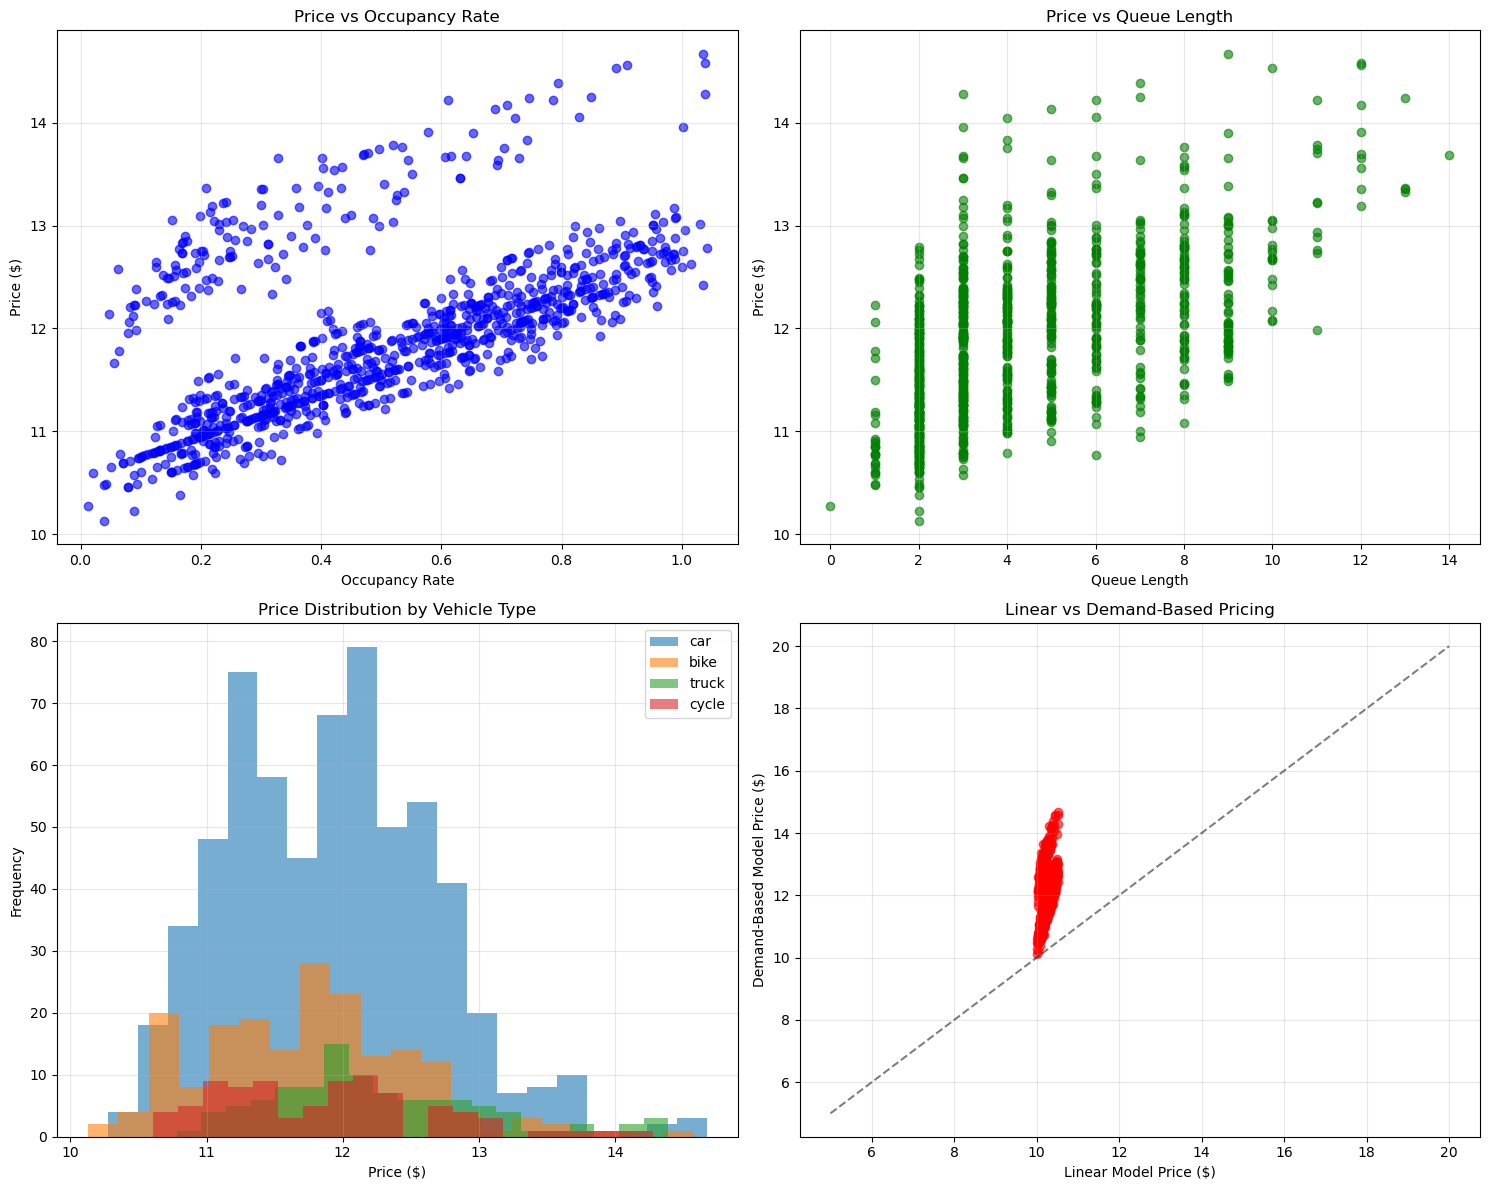


Initializing real-time simulator...
Starting real-time simulation...
Running simulation for 30 seconds...

Latest Pricing Data:
--------------------------------------------------------------------------------
Time: 2016-10-04 08:25:00, Space: 3, Price: $11.28, Occupancy: 44.0%
Time: 2016-10-04 08:25:00, Space: 6, Price: $10.89, Occupancy: 37.0%
Time: 2016-10-04 08:25:00, Space: 14, Price: $10.64, Occupancy: 21.8%
Time: 2016-10-04 08:25:00, Space: 7, Price: $11.33, Occupancy: 39.0%
Time: 2016-10-04 08:25:00, Space: 10, Price: $10.47, Occupancy: 8.5%
Time: 2016-10-04 08:25:00, Space: 5, Price: $11.34, Occupancy: 39.6%
Time: 2016-10-04 08:25:00, Space: 2, Price: $10.82, Occupancy: 26.2%
Time: 2016-10-04 08:25:00, Space: 1, Price: $10.62, Occupancy: 11.1%
Time: 2016-10-04 08:59:00, Space: 8, Price: $11.23, Occupancy: 39.2%
Time: 2016-10-04 08:59:00, Space: 11, Price: $11.35, Occupancy: 40.1%

Simulation completed!
Analysis plots saved as 'parking_pricing_analysis.png'

Summary Statistics:

In [9]:
# ===========================
# MAIN EXECUTION
# ===========================

def main():
    """Main function to run the parking pricing system"""
    print("Starting Dynamic Parking Pricing System...")
    
    # Initialize pricing engine
    pricing_engine = analyze_pricing_scenarios()
    
    # Create static analysis
    print("\nGenerating static analysis plots...")
    sample_data = create_static_analysis()
    
    # Initialize simulator
    print("\nInitializing real-time simulator...")
    simulator = RealTimeSimulator(df, pricing_engine, update_interval=1)
    
    # Start simulation
    print("Starting real-time simulation...")
    simulator.start()
    
    # Run for a demo period
    print("Running simulation for 30 seconds...")
    time.sleep(30)
    
    # Get and display results
    latest_data = simulator.get_latest_data(20)
    if latest_data:
        print("\nLatest Pricing Data:")
        print("-" * 80)
        for i, data in enumerate(latest_data[-10:]):  # Show last 10 records
            print(f"Time: {data['Timestamp']}, Space: {data['ParkingSpaceID']}, "
                  f"Price: ${data['Price']:.2f}, Occupancy: {data['OccupancyRate']:.1%}")
    
    # Stop simulation
    simulator.stop()
    
    print("\nSimulation completed!")
    print("Analysis plots saved as 'parking_pricing_analysis.png'")
    
    # Summary statistics
    if latest_data:
        prices = [d['Price'] for d in latest_data]
        occupancy_rates = [d['OccupancyRate'] for d in latest_data]
        
        print(f"\nSummary Statistics:")
        print(f"Average Price: ${np.mean(prices):.2f}")
        print(f"Price Range: ${np.min(prices):.2f} - ${np.max(prices):.2f}")
        print(f"Average Occupancy: {np.mean(occupancy_rates):.1%}")
        print(f"Total Data Points Processed: {len(latest_data)}")

if __name__ == "__main__":
    main()